In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from scipy import stats


Available Markets: ['Atlanta' 'Austin' 'Baltimore' 'Boston' 'Charlotte' 'Chicago Suburbs'
 'Dallas-Ft. Worth' 'Denver-Boulder' 'Detroit' 'Downtown Chicago'
 'Houston' 'Los Angeles' 'Nashville' 'Manhattan' 'Northern New Jersey'
 'Northern Virginia' 'Orange County (CA)' 'Philadelphia' 'Phoenix'
 'Raleigh-Durham' 'Salt Lake City' 'San Diego' 'San Francisco' 'Seattle'
 'South Bay' 'South Florida' 'Suburban Maryland' 'Tampa' 'US National'
 'Washington DC']
Available Classes: ['A' 'O']

Descriptive Statistics:

San Francisco:
       period internal_class internal_class_rent            \
                                            mean       std   
0  Post-COVID              A           75.000918  0.719386   
1  Post-COVID              O           63.291907  3.937019   
2   Pre-COVID              A           78.209448  7.836996   
3   Pre-COVID              O           68.567878  3.907183   
4  Transition              A           80.928035  5.385565   
5  Transition              O           7

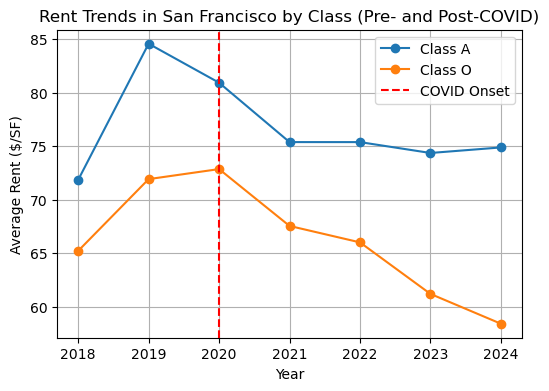

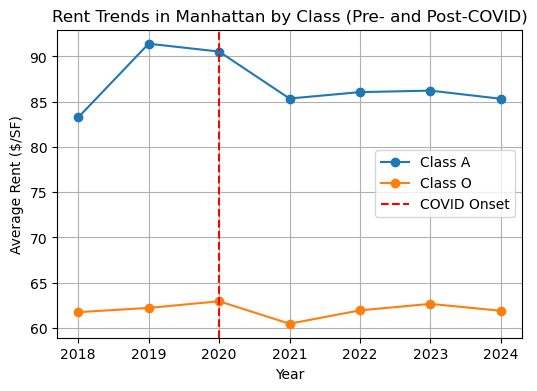

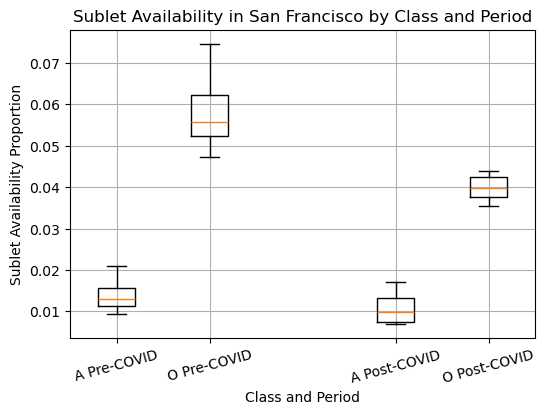

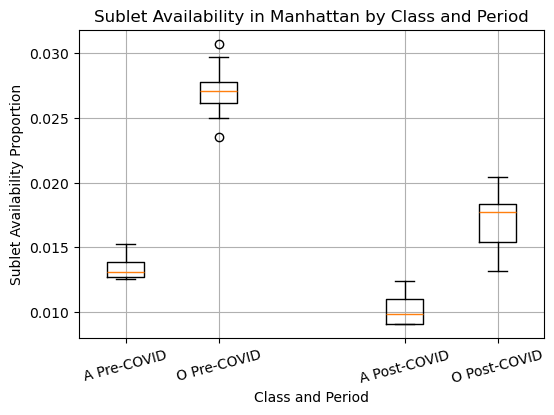

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Path to data
path = "2025 ASA DataFest-update2-2025-03-19/"

# Load datasets
try:
    leases_df = pd.read_csv(path + "Leases.csv")
    prices_df = pd.read_csv(path + "Price and Availability Data.csv")
    occupancy_df = pd.read_csv(path + "Major Market Occupancy Data-revised.csv")
    unemployment_df = pd.read_csv(path + "Unemployment.csv")
except FileNotFoundError as e:
    print(f"Error: {e}. Please verify the file path: {path}")
    exit()

# Check available markets and classes
print("Available Markets:", prices_df["market"].unique())
print("Available Classes:", prices_df["internal_class"].unique())

# Specify cities
cities = ["San Francisco", "Manhattan"]  # Adjust based on available markets
if not all(city in prices_df["market"].unique() for city in cities):
    print(f"Warning: One or both cities not found. Available markets: {prices_df['market'].unique()}")
    exit()

# Check Class O
available_classes = prices_df["internal_class"].unique()
if "O" not in available_classes:
    print("Warning: Class O not found. Using Class C instead.")
    classes = ["A", "C"]
else:
    classes = ["A", "O"]

# Filter for cities and classes
leases_df = leases_df[(leases_df["market"].isin(cities)) & (leases_df["internal_class"].isin(classes))]
prices_df = prices_df[(prices_df["market"].isin(cities)) & (prices_df["internal_class"].isin(classes))]
occupancy_df = occupancy_df[occupancy_df["market"].isin(cities)]

# Assign periods
def assign_period(year):
    if year <= 2019:
        return "Pre-COVID"
    elif year >= 2021:
        return "Post-COVID"
    else:
        return "Transition"

leases_df["period"] = leases_df["year"].apply(assign_period)
prices_df["period"] = prices_df["year"].apply(assign_period)
occupancy_df["period"] = occupancy_df["year"].apply(assign_period)
unemployment_df["period"] = unemployment_df["year"].apply(assign_period)

# Clean data
leases_df = leases_df.dropna(subset=["internal_class_rent", "availability_proportion"])
prices_df = prices_df.dropna(subset=["internal_class_rent", "availability_proportion"])
occupancy_df = occupancy_df.dropna(subset=["avg_occupancy_proportion"])
unemployment_df = unemployment_df.dropna(subset=["unemployment_rate"])

# Aggregate prices_df
prices_agg = prices_df.groupby(["market", "internal_class", "year", "quarter", "period"]).agg({
    "internal_class_rent": "mean",
    "availability_proportion": "mean",
    "sublet_availability_proportion": "mean"
}).reset_index()

# Merge with occupancy
merged_df = pd.merge(
    prices_agg,
    occupancy_df[["market", "year", "quarter", "avg_occupancy_proportion", "period"]],
    on=["market", "year", "quarter", "period"],
    how="left"
)

# Descriptive stats by city
print("\nDescriptive Statistics:")
for city in cities:
    city_stats = merged_df[merged_df["market"] == city].groupby(["period", "internal_class"]).agg({
        "internal_class_rent": ["mean", "std"],
        "sublet_availability_proportion": "mean",
        "avg_occupancy_proportion": "mean"
    }).reset_index()
    print(f"\n{city}:")
    print(city_stats)

# T-tests for rent changes
print("\nT-Test Results (Rent Pre- vs. Post-COVID):")
for city in cities:
    print(f"\n{city}:")
    for cls in classes:
        pre_rent = merged_df[(merged_df["market"] == city) & 
                            (merged_df["period"] == "Pre-COVID") & 
                            (merged_df["internal_class"] == cls)]["internal_class_rent"]
        post_rent = merged_df[(merged_df["market"] == city) & 
                             (merged_df["period"] == "Post-COVID") & 
                             (merged_df["internal_class"] == cls)]["internal_class_rent"]
        if len(pre_rent.dropna()) > 1 and len(post_rent.dropna()) > 1:
            t_stat, p_val = stats.ttest_ind(pre_rent.dropna(), post_rent.dropna())
            print(f"Class {cls}: p-value = {p_val:.4f} (significant if < 0.05)")
        else:
            print(f"Class {cls}: Insufficient data for t-test")

# Visualizations
# 1. Rent trends by city
for city in cities:
    plt.figure(figsize=(6, 4))
    city_data = merged_df[merged_df["market"] == city]
    for cls in classes:
        cls_data = city_data[city_data["internal_class"] == cls]
        yearly_rent = cls_data.groupby("year")["internal_class_rent"].mean()
        plt.plot(yearly_rent.index, yearly_rent, label=f"Class {cls}", marker="o")
    plt.axvline(x=2020, color="red", linestyle="--", label="COVID Onset")
    plt.title(f"Rent Trends in {city} by Class (Pre- and Post-COVID)")
    plt.xlabel("Year")
    plt.ylabel("Average Rent ($/SF)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 2. Sublet availability by city
for city in cities:
    plt.figure(figsize=(6, 4))
    city_data = merged_df[merged_df["market"] == city]
    positions = [1, 2, 4, 5]
    labels = [f"{cls} Pre-COVID" for cls in classes] + [f"{cls} Post-COVID" for cls in classes]
    box_data = [
        city_data[(city_data["internal_class"] == cls) & (city_data["period"] == period)]["sublet_availability_proportion"].dropna()
        for cls in classes for period in ["Pre-COVID", "Post-COVID"]
    ]
    plt.boxplot(box_data, positions=positions, widths=0.4)
    plt.xticks(positions, labels, rotation=15)
    plt.title(f"Sublet Availability in {city} by Class and Period")
    plt.xlabel("Class and Period")
    plt.ylabel("Sublet Availability Proportion")
    plt.grid(True)
    plt.show()